In [2]:
import os

os.chdir(
    "/Users/prantaneeldebnath/Downloads/PINN-pde/PINN-bond-pde/main/continuous_time_inference (Schrodinger)"
)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from pyDOE import lhs
import time
from plotting import newfig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D


np.random.seed(43)
tf.random.set_seed(43)

In [32]:
class PhysicsInformedNeuralNetwork:
    def __init__(self, x0, f0, tb, X_f, layers, lb, ub, a, b, sigma):
        """
        X_f = [[x_f_0, t_f_0], [x_f_1, t_f_1], ...] #test input for the function
        x0 = [[x_0_0], [x_0_1], ...] #test input for f(0, x) boundary condition
        u0 = [[u_0_0], [u_0_1], ...] #test output for real(f(0, x)) boundary condition
        v0 = [[v_0_0], [v_0_1], ...] #test output for imag(f(0, x)) boundary condition
        tb = [[t_b_0], [t_b_1], ...] #test input for f(t, lb(x)) and f(t, ub(x))
        layers = number of layers in the neural network
        lb = [0.01, 0] #lower bound of [x, t]
        ub = [0.1, 1] #upper bound of [x, t]
        """
        self.lb = tf.constant(lb, dtype=tf.float32)
        self.ub = tf.constant(ub, dtype=tf.float32)
        self.a = tf.constant(a, dtype=tf.float32)
        self.b = tf.constant(b, dtype=tf.float32)
        self.sigma = tf.constant(sigma, dtype=tf.float32)
        # all concats should be of the format [x, t]
        # first we create zipped/concat datasets for the boubndary conditions
        X0 = np.concatenate((x0, 0 * x0), 1)

        # Now we have 4 master input datasets X0, X_ub, X_lb, X_f

        # Now we separate the data for x and t for each of them
        self.X0 = tf.Variable(X0, dtype=tf.float32)
        self.X_f = tf.Variable(X_f, dtype=tf.float32)

        self.f0 = tf.Variable(f0, dtype=tf.float32)

        self.x0 = self.X0[:, 0:1]
        self.t0 = self.X0[:, 1:2]

        self.x_f = self.X_f[:, 0:1]
        self.t_f = self.X_f[:, 1:2]
        # initialize the neural network using weights and biases

        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # initialize an Adam optimizer6
        self.optimizer_Adam = tf.keras.optimizers.legacy.Adam(0.001)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(
                tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32
            )
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev),
            dtype=tf.float32
        )

    def loss_function(self):
        loss = (
            tf.reduce_mean(tf.square(self.f0 - self.f0_pred))
            + tf.reduce_mean(tf.square(self.f_pred))
        )
        return loss

    def neural_net(self, X, weights, biases):
        """
        Calculates the forward pass value of the neural network for a given input
        """
        num_layers = len(weights) + 1
        
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        H = tf.cast(H, dtype=tf.float32)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_uv(self, x, t):
        """
        Calculates the u, v, u_x, v_x for a given x, t input using the neural_ne0t
        """
  
         
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            X = tf.concat([x, t], 1)
            f = self.neural_net(X, self.weights, self.biases)
            
        f_x = tape.gradient(f, x)
        del tape
        return f, f_x

    def net_f_uv(self, x, t, a, b, sigma):
        """
        Returns the value of the function
        """
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            f, f_x = self.net_uv(x, t)
            
        f_t = tape.gradient(f, t)
        f_xx = tape.gradient(f_x, x)
        
        f_F = b*(a-x)*f_x + 0.5*(sigma**2)*x*f_xx - f_t - x*f

        del tape
        return f_F

    def callback(self, loss):
        print("Loss:", loss)

    def train(self, nIter):
        start_time = time.time()

        for it in range(nIter):
            with tf.GradientTape() as tape:
                
                self.f0_pred, _ = self.net_uv(self.x0, self.t0)
                
                
                self.f_pred = self.net_f_uv(self.x_f, self.t_f, self.a, self.b, self.sigma)

                self.loss = self.loss_function()
            
            grad = tape.gradient(self.loss, list(self.weights) + list(self.biases))

            self.optimizer_Adam.apply_gradients(
                zip(grad, list(self.weights) + list(self.biases))
            )
            if (it + 1) % 100 == 0:
                print(f"Iteration {it + 1}, Loss : {self.loss.numpy()}")

    def predict(self, X_star):
        X_star = tf.constant(X_star, dtype=tf.float32)
        x_pred = X_star[:, 0:1]
        t_pred = X_star[:, 1:2]

        f_pred, _ = self.net_uv(x_pred, t_pred)
        f_F_pred = self.net_f_uv(x_pred, t_pred, self.a, self.b, self.sigma)

        return f_pred.numpy(), f_F_pred.numpy()



In [35]:

noise = 0.0

# Doman bounds
lb = np.array([0.01, 0.0])
ub = np.array([0.1, 1.0])

b = 0.8
a = 0.1
sigma=0.005

N0 = 50  # number of points for time = 0
N_b = 50  # number of points for boundary
N_f = 10000  # number of simulated solutions to the PDE
layers = [2, 100, 100, 100, 100, 100, 1]
# 4 hidden layers with 100 neurons
# output is f solution of the pde
# input is x, t

data = np.genfromtxt('cir_data.csv', delimiter=',', dtype=None, names=True)
t = np.unique(data["time"]).flatten()[:, None]  # time data indexed
x = np.unique(data["rate"]).flatten()[:, None]  # position data indexed [[-1], [0], [1], ...]
Exact = data["price"]  # exact imaginary simulated points
#     # exact is a grid of values for all the t and x points correspondingly
#     Exact_u = np.real(Exact)  # real part of the exact point
#     Exact_v = np.imag(Exact)  # imaginary part of the exact point
#     Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)  # modulus of the exact point

# Exact_u of the form [[a1, 0], [a2, 0], [a3, 0], ... ]

X, T = np.meshgrid(x, t)
#     # create a mesh grid with the available t, x points pairwise
#     # for X, x is constant downwards and changes columnwise-wise
#     # for T, its constant columnwise and changes row-wise
X_star = np.hstack(
    (data["rate"].flatten()[:, None], data["time"].flatten()[:, None])
)  # [[x1, t1], [x2, t1], [x3, t1], ...., [xN, tM]]
#     # concats both arrays across the second axis
f_star = Exact.T.flatten()[
    :, None
]  # for each X_star the corresponding output u_star
#     v_star = Exact_v.T.flatten()[
#         :, None
#     ]  # for each X_star the corresponding output v_star
#     h_star = Exact_h.T.flatten()[
#         :, None
#     ]  # for each X_star the corresponding output h_star
###########################

idx_x = np.random.choice(x.shape[0], N0, replace=False)
#     # random x indices for N0 size choices
x0 = x[idx_x, :]  # N0 position values vector
f0 = np.ones((N0, 1)) # f values only for time 0 for all those x0
#     v0 = Exact_v[idx_x, 0:1]  # v values only for time 0 for all those x0

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :]  # choose N_b values of time from time array
X_f = lb + (ub - lb) * lhs(2, N_f)
# print(X_star)
# creates random points of size N_f
model = PhysicsInformedNeuralNetwork(x0, f0, tb, X_f, layers, lb, ub, a, b, sigma)

#training
start_time = time.time()
model.train(5000)
elapsed = time.time() - start_time
print("Training time: %.4f" % (elapsed))
f_pred, f_F_pred = model.predict(X_star)
error_f = np.linalg.norm(f_star-f_pred,2)/np.linalg.norm(f_star,2)
print('Error f: %e' % (error_f))


#     U_pred = griddata(X_star, f_pred.flatten(), (X, T), method='cubic')

# #     FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
# #     FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     
#     ######################################################################
#     ############################# Plotting ###############################
#     ######################################################################    

#     X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
#     X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
#     X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
#     X_u_train = np.vstack([X0, X_lb, X_ub])

#     fig, ax = newfig(1.0, 0.9)
#     ax.axis('off')

# #     ####### Row 0: h(t,x) ##################    
#     gs0 = gridspec.GridSpec(1, 2)
#     gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
#     ax = plt.subplot(gs0[:, :])

#     h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
#                   extent=[lb[1], ub[1], lb[0], ub[0]], 
#                   origin='lower', aspect='auto')
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(h, cax=cax)

#     ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

#     line = np.linspace(x.min(), x.max(), 2)[:,None]
#     ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
#     ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
#     ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

#     ax.set_xlabel('$t$')
#     ax.set_ylabel('$x$')
#     leg = ax.legend(frameon=False, loc = 'best')
# #    plt.setp(leg.get_texts(), color='w')
#     ax.set_title('$|h(t,x)|$', fontsize = 10)

#     ####### Row 1: h(t,x) slices ##################    
#     gs1 = gridspec.GridSpec(1, 3)
#     gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

#     ax = plt.subplot(gs1[0, 0])
#     ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
#     ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$|h(t,x)|$')    
#     ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
#     ax.axis('square')
#     ax.set_xlim([-5.1,5.1])
#     ax.set_ylim([-0.1,5.1])

#     ax = plt.subplot(gs1[0, 1])
#     ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
#     ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$|h(t,x)|$')
#     ax.axis('square')
#     ax.set_xlim([-5.1,5.1])
#     ax.set_ylim([-0.1,5.1])
#     ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

#     ax = plt.subplot(gs1[0, 2])
#     ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
#     ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
#     ax.set_xlabel('$x$')
#     ax.set_ylabel('$|h(t,x)|$')
#     ax.axis('square')
#     ax.set_xlim([-5.1,5.1])
#     ax.set_ylim([-0.1,5.1])    
#     ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)
#     plt.show()


Iteration 100, Loss : 0.000711561762727797
Iteration 200, Loss : 0.00042254841537214816
Iteration 300, Loss : 0.0002490977058187127
Iteration 400, Loss : 0.0001434289151802659
Iteration 500, Loss : 8.62342058098875e-05
Iteration 600, Loss : 5.5020856962073594e-05
Iteration 700, Loss : 6.143503560451791e-05
Iteration 800, Loss : 3.617502807173878e-05
Iteration 900, Loss : 2.463906457705889e-05
Iteration 1000, Loss : 0.00012118369340896606
Iteration 1100, Loss : 2.3666530978516676e-05
Iteration 1200, Loss : 1.5338788216467947e-05
Iteration 1300, Loss : 1.0983188985846937e-05
Iteration 1400, Loss : 8.193065696104895e-06
Iteration 1500, Loss : 3.2619158446323127e-05
Iteration 1600, Loss : 9.810179108171724e-06
Iteration 1700, Loss : 7.361964435403934e-06
Iteration 1800, Loss : 5.914439043408493e-06
Iteration 1900, Loss : 5.017499461246189e-06
Iteration 2000, Loss : 1.4197210475686006e-05
Iteration 2100, Loss : 6.4013779592642095e-06
Iteration 2200, Loss : 5.164011781744193e-06
Iteration 23

In [8]:
f_pred

array([[0.9995038 ],
       [0.9995003 ],
       [0.99949706],
       ...,
       [0.88217527],
       [0.8820277 ],
       [0.8818788 ]], dtype=float32)

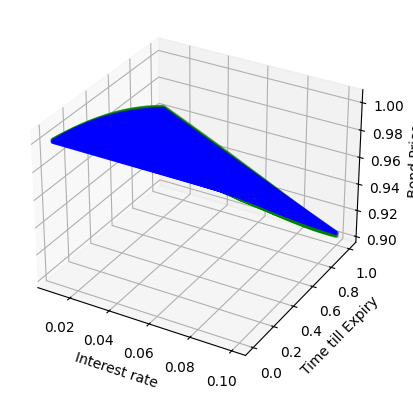

In [36]:
fig = plt.figure()
    
ax = fig.add_subplot(projection = '3d')


ax.scatter(X.flatten(), T.flatten(), f_pred.flatten(), marker='.', color='green')
ax.scatter(X.flatten(), T.flatten(), data["price"].flatten(), marker='.', color='blue')

ax.set_xlabel('Interest rate')
ax.set_ylabel('Time till Expiry')
ax.set_zlabel('Bond Price')

plt.show()


In [27]:
x0

array([[0.02818182],
       [0.01181818],
       [0.02363636],
       [0.03      ],
       [0.06181818],
       [0.09272727],
       [0.07272727],
       [0.06      ],
       [0.02      ],
       [0.08181818],
       [0.01818182],
       [0.04454545],
       [0.08727273],
       [0.01      ],
       [0.09090909],
       [0.02181818],
       [0.01454545],
       [0.01090909],
       [0.09636364],
       [0.08545455],
       [0.05      ],
       [0.02090909],
       [0.08090909],
       [0.09545455],
       [0.04363636],
       [0.09363636],
       [0.09818182],
       [0.06090909],
       [0.06727273],
       [0.05181818],
       [0.01727273],
       [0.04      ],
       [0.05090909],
       [0.02727273],
       [0.02272727],
       [0.09454545],
       [0.07636364],
       [0.04545455],
       [0.03181818],
       [0.01545455],
       [0.06636364],
       [0.03090909],
       [0.02636364],
       [0.04818182],
       [0.08272727],
       [0.08818182],
       [0.03818182],
       [0.070